# Maze Solver Tutorial #

### Documentation ###
- Medium Michael Gold - [Link](https://medium.com/@msgold/using-python-to-create-and-solve-mazes-672285723c96);
- Git ```mazeSolver``` - [Link](https://github.com/YeyoM/mazeSolver);

### Methodologies ###
**```BFS```**<br>
```BFS``` *explores all eligible neighbors of the current cell before moving on*. This guarantees that it will find the shortest path from the starting point to the target.

We implement a ```bfs_queue``` to keep *track of the cells that have been visited*. Each element in ```bfs_queue``` is a tuple of the ```current cell``` and the ```path``` taken to reach it (which allows the algorithm to keep track of previous steps).

We start by *adding the ```start cell``` and an ```empty path``` to ```bfs_queue```*. Then, as long as ```bfs_queue``` is not empty, we *take the last element from it and explore its neighbors, adding them to the queue (one at a time)*. We *only move to a neighbor cell if it's ```open``` and ```has not been visited``` before*.

When we reach the ```target cell```, we update the path taken to reach it to ```bfs_solution```. 

**```A*``` (```A Star```)**<br>
```A*``` *always explores the eligible neighbor of the current cell with the smallest cost* (in our case, an approximation of the shortest distance from ```origin``` to ```target```). This guarantees that it will find the shortest cost distance without exploring more costly paths.

We implement a ```astar_queue``` to keep *track of the cells that have been visited*. Each element in ```astar_queue``` is a tuple of the ```f_cost```, ```cell``` and ```path``` taken to reach it (which allows the algorithm to keep track of previous steps).

We also implement 3 maps (with same shape as ```grid```) all filled with ```inifinte``` (a proxy for unknown): 
- ```g_cost```: the actual cost of travelling from ```start``` to (current) ```cell```;
- ```h_cost```: the heuristic cost of travelling from (current) ```cell``` to ```target``` (this cost is an ```Manhattan``` estimation, since we haven't explored anything between ```cell``` and ```target```);
- ```f_cost```: the sum of ```g_cost``` and ```h_cost``` (the main metric);

We start by *adding the ```start cell```, its ```f_cost``` and an ```empty path``` to ```astar_queue```*. Then, as long as ```astar_queue``` is not empty, we *take the cheapest element from it, explore its eligible neighbors, choosing any of them with a smaller cost and adding it to the queue (one at a time)*. 

When we reach the ```target cell```, we update the path taken to reach it to ```astar_solution```.

**```Dijkstra```**<br>
```Dijkstra``` *always explores all eligible neighbor of the current cell, choosing the one with the smallest distance to move to*. . This guarantees that it will find the shortest cost distance, but at the expense of exploring paths until a *cheaper on is found* (which the becomes the main exploring route).

We implement a ```dijkstra_queue``` to keep *track of all cells in the ```grid```*. Each element in ```dijkstra_queue``` is a tuple of the ```distance```, ```cell``` and ```path``` taken to reach it (which allows the algorithm to keep track of previous steps).

We start by *adding the ```start cell```, its ```distance``` and an ```empty path``` to ```dijkstra_queue```*. Then, as long as ```dijkstra_queue``` is not empty, we *take the cheapest element from it, explore its eligible neighbors, choosing any of them with a smaller distance and re-adding it to the queue (as an update)*. 

When we reach the ```target cell```, we update pull the last path taken to reach it and assign it to ```dijkstra_solution```.

### Importing Dependencies ###

In [1]:
import yaml
import numpy as np
from queue import PriorityQueue

import matplotlib.pyplot as plt
%matplotlib inline

### User-Defined Classes ###

In [83]:
class MazeSolver(object): 
    def __init__(self):
        # Grid ([Values] 0: Path; 1: Wall)
        self.grid = self.read_txt()
        # Entrance/Exit Coords
        self.start = self.set_entrance() # [tuple]
        self.end = self.set_exit() # [tuple]
        # BFS Solver
        self.bfs_queue = [] # LIFO Queue 
        self.bfs_solution = None
        # A* Solver
        self.astar_queue = PriorityQueue() 
        self.astar_solution = None
        # Dijkstra Solver
        self.dijkstra_queue = PriorityQueue() 
        self.dijkstra_solution = None

    # Grid Methods
    def read_txt(self, path="./maze_example.txt"): 
        return np.genfromtxt(path, delimiter=",") # [np.ndarray]
    
    # Entrance/Exit Methods
    def set_entrance(self): 
        return (1,0) # [default:tuple]

    def set_exit(self): 
        length = len(self.grid)
        return (length - 2, length - 1) # '-2'/'-1': compensating for 0-index and borders
                                        # [default:tuple]

    # BFS Methods
    def solve_bfs(self):
        # Assessing candidate moves
        offset = [(1, 0), (-1,0), (0, 1), (0, -1)] # Move Right, Move Left, Move Up, Move Down
        # Creating a boolean map for visited cells
        visited = np.zeros_like(self.grid, dtype=bool) # All False
        visited[self.start] = True # Visiting 'start'
        # Starting the 'self.bfs_queue'
        self.bfs_queue.append((self.start, []))
        # Looping...
        while self.bfs_queue:
            # Update current cell with queue's last element
            (cell, path) = self.bfs_queue.pop()
            # Looping moves...
            for dx, dy in offset:
                # Updates next cell
                next_cell = (cell[0] + dx, cell[1] + dy) # [tuple]
                # Reached the exit?
                if (next_cell == self.end):
                    self.bfs_solution = path + [next_cell] # Main output
                # If 1) within grid / 2) 'next_cell' is a path (0) / 3) 'next_cell' wasn't visited before
                if (0 < next_cell[0] < self.grid.shape[0] - 1) and (0 < next_cell[1] < self.grid.shape[1] - 1) \
                   and (self.grid[next_cell] == 0) \
                   and (not visited[next_cell]): 
                    # Visiting 'next_cell'
                    visited[next_cell] = True
                    # Appending to 'self.bfs_queue'
                    self.bfs_queue.append((next_cell, path + [next_cell]))

    # A* Methods
    def solve_astar(self): 
        # Assessing candidate moves
        offset = [(1, 0), (-1,0), (0, 1), (0, -1)] # Move Right, Move Left, Move Up, Move Down
        # Actual Cost to reach cell from start 
        g_cost = np.zeros_like(self.grid, dtype=float) # Using 'np.zeros_like' instead of 'np.full' to avoid 'ndarray's dimension limit (32)
        g_cost[True] = np.inf # Setting all elements to infinite (since we haven't visited anything yet)
        g_cost[self.start] = 0 
        # Heuristic/Estimated Cost to reach target from cell (uses Manhattan distance)
        h_cost = np.zeros_like(self.grid, dtype=float) # Using 'np.zeros_like' instead of 'np.full' to avoid 'ndarray's dimension limit (32)
        h_cost[True] = np.inf # Setting all elements to infinite (since we haven't visited anything yet)
        h_cost[self.start] = self.manhattan(self.start)
        # Total Cost
        f_cost = g_cost + h_cost
        # Starting the 'self.astar_queue'
        self.astar_queue.put((f_cost[self.start], self.start, [])) # Format: (f_cost, cell, path)
                                                                   # Priority Queue Pattern: (priority_number, data)
        # Looping...
        while not self.astar_queue.empty():
            # Update current cell with queue's lowest 'f_cost'
            (curr_f, cell, path) = self.astar_queue.get()
            # If 'target' is reached
            if cell == self.end:
                break # Reached the end
            # Looping moves...
            for dx, dy in offset:
                # Updates next cell
                next_cell = (cell[0] + dx, cell[1] + dy) # [tuple] 
                # If it's a path (0)...
                if self.grid[next_cell] == 0:
                    # Calculating temporary 'g_cost' and 'h_cost'
                    temp_g_cost = g_cost[cell] + 1
                    temp_h_cost = self.manhattan(next_cell)
                    temp_f_cost = temp_g_cost + temp_h_cost
                    # Confirming found 'f_cost' for neighbor is smaller than previoulsy known
                    if temp_f_cost < f_cost[next_cell]: # If neighbor is unvisited, 'f_cost[next_cell]' is infinite
                        # Updating 'g_cost' and 'h_cost'
                        g_cost[next_cell] = temp_g_cost
                        h_cost[next_cell] = temp_h_cost
                        f_cost[next_cell] = temp_f_cost
                        # Adding 'next_cell' in queue and solution
                        self.astar_queue.put((f_cost[next_cell], next_cell, path + [next_cell]))
                        self.astar_solution = path + [next_cell] # Main output

    def manhattan(self, cell):
        return abs(cell[0] - self.end[0]) + abs(cell[1] - self.end[1]) # 'cell': current cell / 'self.end': target cell

    # Dijkstra Methods
    def solve_dijkstra(self):
        # Assessing candidate moves
        offset = [(1, 0), (-1,0), (0, 1), (0, -1)] # Move Right, Move Left, Move Up, Move Down
        # Distance to reach cell from start 
        distance = np.zeros_like(self.grid, dtype=float) # Using 'np.zeros_like' instead of 'np.full' to avoid 'ndarray's dimension limit (32)
        distance[True] = np.inf # Setting all elements to infinite (since we haven't visited anything yet)
        distance[self.start] = 0 
        # Populating 'self.dijkstra_queue' with all cells
        for x, x_row in enumerate(distance):
            for y, value in enumerate(x_row):
                cell = (x,y)
                self.dijkstra_queue.put((distance[cell], cell, []))
        # Looping...
        while not self.dijkstra_queue.empty():
            # Update current cell with queue's lowest 'distance'
            (curr_dist, cell, path) = self.dijkstra_queue.get() 
            # If 'target' is reached
            if cell == self.end:
                self.dijkstra_solution = path # Main output
                break # Reached the end
            # Looping moves...
            for dx, dy in offset:
                # Updates next cell
                next_cell = (cell[0] + dx, cell[1] + dy) # [tuple] 
                # If it's a path (0)...
                if self.grid[next_cell] == 0:
                    # Calculating the neighbor's distance
                    temp_dist = curr_dist + 1
                    # Confirming neighbor's 'temp_dist' is smaller than found in 'distance'
                    if temp_dist < distance[next_cell]: # If neighbor is unvisited, 'distance[next_cell]' is infinite
                        # Updating 'distance' and 'previous'
                        distance[next_cell] = temp_dist
                        # Updating 'next_cell' in queue
                        self.dijkstra_queue.put((distance[next_cell], next_cell, path + [next_cell]))

    # Plot Methods
    def plot_maze(self, solver="bfs"): # (Available) 'solver': 'bfs', 'astar', 'dijkstra'
        # Preparing the data
        x = list(range(len(self.grid)))
        y = list(range(len(self.grid)))
        z = self.grid
        sol_x = [cell[0] for cell in getattr(self, "{}_solution".format(solver))] # Dynamically pulls corresponding solution
        sol_y = [cell[1] for cell in getattr(self, "{}_solution".format(solver))]
        ## Plot
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), dpi=120)
        # ColorMesh
        ax.pcolormesh(x, y, z, vmin=np.min(z), vmax=np.max(z), shading="auto", cmap="binary")
        # Entrance/Exit
        ax.scatter(self.start[1], self.start[0], s=15, marker="*", color="green") # Inverting coords since axis are inverted
        ax.scatter(self.end[1], self.end[0], s=15, marker="*", color="red")
        # Line
        ax.plot(sol_y, sol_x, color="firebrick", linewidth=2)
        # Aspect
        ax.set_box_aspect(1)
        # Axis Labels
        ax.set_xlabel("y", fontsize=10)
        ax.set_ylabel("x", fontsize=10)
        # Axis Color
        ax.spines["left"].set_color(None)
        ax.spines["right"].set_color(None)
        # Ticks
        ax.tick_params(axis= "both", which= "both", color= "gray", labelsize= 4) 
        ax.set_xticks(x, labels= x) 
        ax.set_yticks(y, labels= y)
        ax.set_xticklabels(x, ha= "center", va= "center") 
        ax.set_yticklabels(y, ha= "right", va= "center") 
        # Title
        ax.set_title("'{}' Maze Solver".format(solver), loc="center", fontsize=10, fontname="Helvetica", pad=10)
        # Grid
        ax.grid(which= "both", color= "gray", alpha=0.25)

### Main ###

In [84]:
# Reading the YAML config
with open("./mazes.yaml", "r") as _stream:
    yaml_config = yaml.safe_load(_stream)

In [85]:
# Instantiating the 'MazeSolver' class: 
maze = MazeSolver()

In [86]:
# Solving the maze via BFS
maze.solve_bfs()
# Solving the maze via A*
maze.solve_astar()
# Solving the maze via Dijkstra
maze.solve_dijkstra()

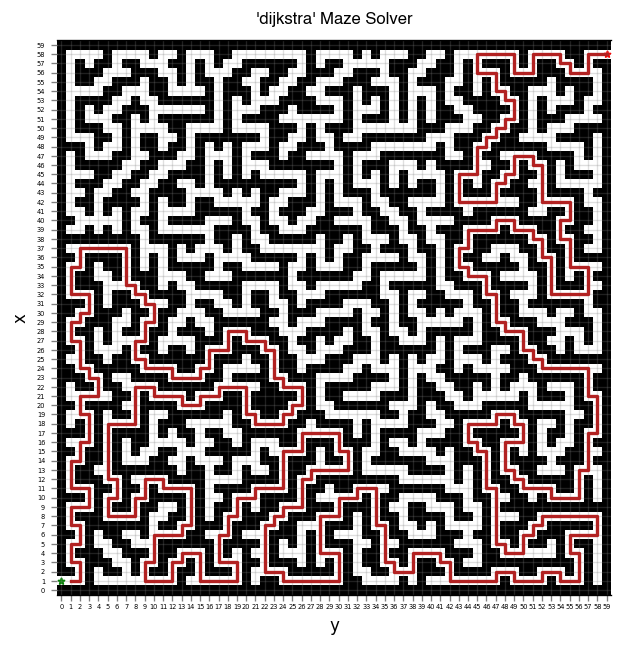

In [87]:
# Plotting the maze
maze.plot_maze(solver="dijkstra") # (Available): 'bfs', 'astar', 'dijkstra'

---